# 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

In [5]:
'''
インポート群
なるべく問題ごとにインポートしていますが，抜けがないように一応上にまとめています．
'''
import torch 
import pandas as pd
from gensim.models import KeyedVectors
import re
from matplotlib import pyplot as plt
import math
import time

### 70. 単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．

In [1]:
from gensim.models import KeyedVectors

# gensimでバイナリファイルをロード
model = KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin", binary=True)

In [5]:
import pandas as pd
import re
code_regex = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]')

def to_vec(file_name):
    df = pd.read_csv(file_name, sep='\t', encoding='utf-8', names=['label', 'text'])

    X = []
    Y = []
    for label, text in zip(df['label'], df['text']):
        words = text.split(' ')
        x = 0
        for word in words:
            word = code_regex.sub('', word)
            if word in model:
                x += model[word]
        X.append(x / len(words))

        if label == "b":
            Y.append(0)
        elif label == "t":
            Y.append(1)
        elif label == "e":
            Y.append(2)
        elif label == "m":
            Y.append(3)

    return pd.DataFrame(X), pd.DataFrame(Y)
def save_file(file_name, type_, df):
    df.to_csv(f'{file_name}.{type_}.txt', index=False, header=False)

In [14]:
train_X, train_Y = to_vec('train.txt')
valid_X, valid_Y = to_vec('valid.txt')
test_X, test_Y = to_vec('test.txt')

save_file('train', 'feature', train_X)
save_file('train', 'label', train_Y)
save_file('valid', 'feature', valid_X)
save_file('valid', 'label', valid_Y)
save_file('test', 'feature', test_X)
save_file('test', 'label', test_Y)

### 71. 単層ニューラルネットワークによる予測

In [15]:
import torch
import pandas as pd

train_feature_df = pd.read_csv('train.feature.txt', sep=',', encoding='utf-8', header=None)
train_label_df = pd.read_csv('train.label.txt', encoding='utf-8', names=['label'])
train_X = torch.FloatTensor(train_feature_df.values)
train_Y = torch.tensor(train_label_df['label'].T.values)

W = torch.randn(1, 300)

# Softmaxを求める
y_ = torch.nn.Softmax(train_X[0]*W)
Y_ = torch.nn.Softmax(train_X[:4]*W)
print(f'{y_} {Y_}')

Softmax(
  dim=tensor([[-6.5108e-02, -1.0930e-03, -2.3298e-01, -1.8984e-02,  3.9312e-03,
            5.7061e-02, -7.1257e-02,  4.3544e-02,  2.1496e-04, -3.7109e-02,
            5.2183e-02,  1.8067e-05, -3.0151e-02, -7.9308e-02, -2.7266e-01,
           -4.0155e-02,  2.1576e-01, -4.0615e-02, -2.7272e-02,  2.3310e-04,
           -1.2913e-01,  8.3592e-03,  2.8015e-02,  1.6783e-02, -3.2330e-02,
            1.1479e-02, -6.8877e-02,  6.4450e-02, -2.6369e-03, -1.9167e-02,
           -1.0286e-02, -9.5810e-02, -4.3772e-03,  3.2742e-01,  4.0957e-02,
            2.6790e-02, -1.1797e-01,  1.6925e-03,  6.1375e-02,  7.0242e-02,
            2.6556e-02,  6.2486e-02,  2.6346e-02,  1.2383e-01,  1.5918e-02,
           -2.9260e-02, -1.2560e-01, -1.0451e-01, -1.0441e-01,  8.7027e-02,
            1.0720e-01,  4.3246e-02, -2.9030e-02,  3.2734e-02,  6.8453e-02,
           -8.3634e-03,  2.1616e-02,  1.4139e-01,  2.2072e-02,  1.4379e-02,
           -7.1021e-02, -3.2148e-02, -3.2695e-01,  1.0742e-02, -7.6818e-03,

### 72. 損失と勾配の計算
学習データの事例x1と事例集合x1,x2,x3,x4に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．なお，ある事例xiに対して損失は次式で計算される．

li=−log[事例xiがyiに分類される確率]<br><br>
ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [44]:
import torch 
import pandas as pd

train_feature_df = pd.read_csv('train.feature.txt', sep=',', encoding='utf-8', header=None)
train_label_df = pd.read_csv('train.label.txt', encoding='utf-8', names=['label'])
train_X = torch.FloatTensor(train_feature_df.values)
train_Y = torch.tensor(train_label_df['label'].values)

# クロスエントロピーをインスタンス化
criterion = torch.nn.CrossEntropyLoss()

# x1に対する損失と勾配を求める
W_x1 = torch.randn(1, 300, requires_grad=True)
y_ = torch.nn.functional.log_softmax(train_X[0]*W_x1, dim=1)
loss_x1_ = criterion(y_, train_Y[0].unsqueeze(0))
loss_x1 = loss_x1_.item()
loss_x1_.backward()

# x1-x4に対する損失と勾配を求める
W_ave = torch.randn(1, 300, requires_grad=True)
loss_ave = 0
loss_ave_ = 0
for i in range(4):
    y_ = torch.nn.functional.log_softmax(train_X[i]*W_ave, dim=1)
    loss_ave_ += criterion(y_, train_Y[i].unsqueeze(0))
    loss_ave += loss_ave_.item()
loss_ave = loss_ave / 4
loss_ave_.backward()

print(f'Loss(x1): {loss_x1}, Loss(x1-x4): {loss_ave},\ngrad(x1) : {W_x1.grad},\ngrad(x1-x4) : {W_ave.grad}')

Loss(x1): 5.712994575500488, Loss(x1-x4): 14.131285071372986,
grad(x1) : tensor([[ 3.0382e-04, -5.6930e-06,  1.3005e-01, -7.2544e-05, -2.5967e-04,
          4.7762e-04,  2.1195e-04, -3.7418e-04,  8.9838e-06,  6.7767e-05,
          1.9764e-04,  8.3711e-05, -1.3408e-04,  3.3188e-04, -4.7721e-04,
         -1.7866e-04,  3.6263e-04,  1.1378e-04, -3.6162e-04, -2.4501e-06,
          2.9896e-04,  2.6390e-04,  1.4036e-04,  6.9766e-05, -2.1968e-04,
          5.3934e-05, -1.4734e-04,  1.4000e-04, -2.9719e-05, -7.0321e-05,
         -1.0953e-04, -2.5410e-04, -4.4005e-05, -4.0932e-04,  1.5287e-04,
         -2.0772e-04,  2.5252e-04, -3.1092e-05, -3.4634e-04,  2.1287e-04,
         -1.0484e-04, -2.3189e-04, -1.3109e-04,  4.2663e-04,  8.2473e-05,
         -1.1767e-04, -2.8007e-04,  3.3510e-04,  8.3498e-04,  3.9356e-04,
         -3.4812e-04,  2.3851e-04, -3.3512e-04,  2.4321e-04,  3.2736e-04,
          1.9528e-04, -4.0269e-04, -3.0018e-04, -7.4973e-05, -1.2845e-04,
          2.6961e-04, -8.7123e-05, -5.7

## 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [23]:
import torch

class Net(torch.nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(300, 4)

    def forward(self, x):
        return self.fc1(x)

net = Net()

In [29]:
train_Dataset = torch.utils.data.TensorDataset(train_X, train_Y)
train_DataLoader = torch.utils.data.DataLoader(
    dataset=train_Dataset, 
    num_workers=2,
    shuffle=True
    )
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

for epoch in range(10):
    train_loss = 0
    for x, y in train_DataLoader:
        y_pred = net(x)
        loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch:{epoch}, train_loss:{train_loss / len(train_DataLoader)}')

epoch:0, train_loss:0.5063663516406235
epoch:1, train_loss:0.44015545021316377
epoch:2, train_loss:0.40432840928974007
epoch:3, train_loss:0.3813748543081548
epoch:4, train_loss:0.364848788007303
epoch:5, train_loss:0.352369654053698
epoch:6, train_loss:0.34280009475491396
epoch:7, train_loss:0.33509339031619184
epoch:8, train_loss:0.3284113542828519
epoch:9, train_loss:0.3227017670130452


### 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [46]:
import torch

class Net(torch.nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(300, 4)

    def forward(self, x):
        return self.fc1(x)

net = Net()

In [47]:
import torch

# 分類
def categorize(DataLoader):
    correct = 0.0
    for x, y in DataLoader:
        y_pred = net(x)
        correct += 1 if torch.argmax(y_pred).item()==y.item() else 0
    return correct / float(len(DataLoader))

# 学習データでの計測
train_ac = categorize(train_DataLoader)

# 評価データでの計測
test_feature_df = pd.read_csv('test.feature.txt', sep=',', encoding='utf-8', header=None)
test_label_df = pd.read_csv('test.label.txt', encoding='utf-8', names=['label'])
test_Dataset = torch.utils.data.TensorDataset(torch.FloatTensor(test_feature_df.values), torch.tensor(test_label_df['label'].values))
test_DataLoader = torch.utils.data.DataLoader(
    dataset=test_Dataset,
    shuffle=False,
    num_workers=2
)
test_acc = categorize(test_DataLoader)

print(f'学習データでの正解率:{train_ac}\n評価データでの正解率:{test_acc}')

学習データでの正解率:0.533920539730135
評価データでの正解率:0.512743628185907


### 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [48]:
import torch

class Net(torch.nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(300, 4)

    def forward(self, x):
        return self.fc1(x)

net = Net()

In [49]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch

# 学習実行
def run(DataLoader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    losses = []
    accs = []
    for epoch in tqdm(range(10)):
        loss_ = 0
        acc_ = 0
        for x, y in DataLoader:
            y_pred = net(x)
            loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
            loss_ += loss.item()

            acc_ += 1 if torch.argmax(y_pred).item()==y.item() else 0

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(loss_ / len(DataLoader))
        accs.append(acc_ / len(DataLoader))

    return losses, accs

100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


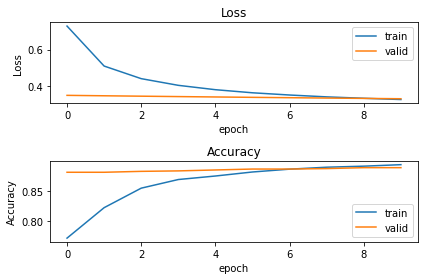

In [50]:
# 検証データでの計測
valid_feature_df = pd.read_csv('valid.feature.txt', sep=',', encoding='utf-8', header=None)
valid_label_df = pd.read_csv('valid.label.txt', encoding='utf-8', names=['label'])
valid_Dataset = torch.utils.data.TensorDataset(torch.FloatTensor(valid_feature_df.values), torch.tensor(valid_label_df['label'].values))
valid_DataLoader = torch.utils.data.DataLoader(
    dataset=valid_Dataset,
    shuffle=False,
    num_workers=2
)

# サブプロットを定義
fig = plt.figure()
g = fig.subplots(2)
epochs = torch.tensor(range(10)).tolist()

# 学習の実行
train_loss, train_acc = run(train_DataLoader)
valid_loss, valid_acc = run(valid_DataLoader)

# 損失をプロット
g[0].plot(epochs, train_loss, label='train')
g[0].plot(epochs, valid_loss, label='valid')
g[0].set_xlabel('epoch')
g[0].set_ylabel('Loss')
g[0].set_title('Loss')
hans, labs = g[0].get_legend_handles_labels()
g[0].legend(handles=hans, labels=labs)

# 正解率をプロット
g[1].plot(epochs, train_acc, label='train')
g[1].plot(epochs, valid_acc, label='valid')
g[1].set_xlabel('epoch')
g[1].set_ylabel('Accuracy')
g[1].set_title('Accuracy')
hans, labs = g[1].get_legend_handles_labels()
g[1].legend(handles=hans, labels=labs)

fig.tight_layout()
plt.show()

### 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [51]:
import torch

class Net(torch.nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(300, 4)

    def forward(self, x):
        return self.fc1(x)

net = Net()

In [55]:
# 問題75のコードをチェックポイントを作成するように改良
def run_check_point(DataLoader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
 
    for epoch in range(10):
        path = 'check_point_epoch_{0}.pth'.format(epoch)
        loss_ = 0
        acc_ = 0
        for x, y in DataLoader:
            y_pred = net(x)

            loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
            loss_ += loss.item()

            acc_ += 1 if torch.argmax(y_pred).item()==y.item() else 0

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'epoch:{epoch}\tloss:{loss_ / len(DataLoader)}')

        torch.save({'model_state_dict':net.state_dict(), 'optimizer_state_sict':optimizer.state_dict()}, path)

In [56]:
run_check_point(train_DataLoader)
run_check_point(test_DataLoader)

epoch:0	loss:0.3182457631712052
epoch:1	loss:0.31391743799550126
epoch:2	loss:0.3102943091708701
epoch:3	loss:0.30679216510574736
epoch:4	loss:0.30360727288588496
epoch:5	loss:0.30090134036873994
epoch:6	loss:0.2984805544221513
epoch:7	loss:0.296260054691163
epoch:8	loss:0.2940326246033649
epoch:9	loss:0.29216733716901583
epoch:0	loss:0.287280008686273
epoch:1	loss:0.2844649918517299
epoch:2	loss:0.282442187388473
epoch:3	loss:0.28053823422007046
epoch:4	loss:0.2786927887752803
epoch:5	loss:0.27689723042309133
epoch:6	loss:0.27514778479697527
epoch:7	loss:0.2734415685913075
epoch:8	loss:0.2717760995121562
epoch:9	loss:0.2701491852465063


## 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [ ]:
import torch

class Net(torch.nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(300, 4)

    def forward(self, x):
        return self.fc1(x)

net = Net()

In [120]:
import time

def run_batch(DataLoader):
    start_time = time.perf_counter()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    for epoch in range(1):
        for x, y in DataLoader:
            y_pred = net(x)
            loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end_time = time.perf_counter()

    return end_time - start_time

In [121]:
import math

batchs = [int(math.pow(2, i)) for i in range(0, 7)]

for batch in batchs:
    train_DataLoader = torch.utils.data.DataLoader(
        dataset=train_Dataset,
        shuffle=True,
        num_workers=2,
        batch_size=batch
    )
    valid_DataLoader = torch.utils.data.DataLoader(
        dataset=valid_Dataset,
        shuffle=False,
        num_workers=2,
        batch_size=batch
    )

    elapsed_time_train = run_batch(train_DataLoader)
    elapsed_time_valid = run_batch(train_DataLoader)

    print(f'batch_size = {batch}\n学習データの経過時間:{elapsed_time_train}\t検証データの経過時間:{elapsed_time_valid}')
    

batch_size = 1
学習データの経過時間:5.041620299998613	検証データの経過時間:4.816708300000755
batch_size = 2
学習データの経過時間:3.1382570000023406	検証データの経過時間:3.1898736000002827
batch_size = 4
学習データの経過時間:2.201504799999384	検証データの経過時間:2.1811730999979773
batch_size = 8
学習データの経過時間:1.6116292999977304	検証データの経過時間:1.6212355999996362
batch_size = 16
学習データの経過時間:1.3281841999996686	検証データの経過時間:1.371978900002432
batch_size = 32
学習データの経過時間:1.2628449000003457	検証データの経過時間:1.1888132999993104
batch_size = 64
学習データの経過時間:1.4122838000002957	検証データの経過時間:1.2024932999993325


## 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

In [ ]:
import torch

class Net(torch.nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(300, 4)

    def forward(self, x):
        return self.fc1(x)

net = Net()

In [125]:
import time

def run_gpu(DataLoader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    net = net.to(device)

    start_time = time.perf_counter()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    for epoch in range(1):
        for x, y in DataLoader:
            y_pred = net(x)
            loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end_time = time.perf_counter()

    return end_time - start_time

In [127]:
import math

batchs = [int(math.pow(2, i)) for i in range(0, 7)]

for batch in batchs:
    train_DataLoader = torch.utils.data.DataLoader(
        dataset=train_Dataset,
        shuffle=True,
        batch_size=batch
    )
    valid_DataLoader = torch.utils.data.DataLoader(
        dataset=valid_Dataset,
        shuffle=False,
        batch_size=batch
    )

    elapsed_time_train = run_batch(train_DataLoader)
    elapsed_time_valid = run_batch(train_DataLoader)

    print(f'batch_size = {batch}\n学習データの経過時間:{elapsed_time_train}\t検証データの経過時間:{elapsed_time_valid}')

batch_size = 1
学習データの経過時間:2.0892134999994596	検証データの経過時間:2.079903900001227
batch_size = 2
学習データの経過時間:1.3210861000006844	検証データの経過時間:1.3508338999999978
batch_size = 4
学習データの経過時間:0.7301151000028767	検証データの経過時間:0.7825517999990552
batch_size = 8
学習データの経過時間:0.46259879999706754	検証データの経過時間:0.4520914000022458
batch_size = 16
学習データの経過時間:0.25706329999957234	検証データの経過時間:0.24774179999803891
batch_size = 32
学習データの経過時間:0.16246449999744073	検証データの経過時間:0.15976950000185752
batch_size = 64
学習データの経過時間:0.12426030000278843	検証データの経過時間:0.127245400002721


## 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [6]:
import torch

# 多層ニューラルネットワークの定義
class Net2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(300, 600)
        self.fc2 = torch.nn.Linear(600, 400)
        self.fc3 = torch.nn.Linear(400, 4)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))

        return torch.nn.functional.log_softmax(self.fc3(x), dim=1)

In [1]:
# 学習の実行
def run_train(DataLoader, net, device):
    net2.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
    
    losses = []
    loss_ = 0
    for x, y in DataLoader:
        x = x.to(device)
        y = y.to(device)
        y_pred = net(x)

        loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
        loss_ += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss_ / len(DataLoader))

    return losses

# 検証データで実行
def run_valid(DataLoader, net, device):
    net.eval()
    criterion = torch.nn.CrossEntropyLoss()
    
    losses = []
    loss_ = 0
    with torch.no_grad(): # 勾配を計算しない
        for x, y in DataLoader:
            x = x.to(device)
            y = y.to(device)
            y_pred = net(x)

            loss = criterion(y_pred, y) # 推論値と正解データの誤差を計算
            loss_ += loss.item()
        
        losses.append(loss_ / len(DataLoader))

    return losses

In [4]:
import pandas as pd
import torch

# 訓練データの読み込み
train_feature_df = pd.read_csv('train.feature.txt', sep=',', encoding='utf-8', header=None)
train_label_df = pd.read_csv('train.label.txt', encoding='utf-8', names=['label'])
train_Dataset = torch.utils.data.TensorDataset(torch.FloatTensor(train_feature_df.values), torch.tensor(train_label_df['label'].values))
train_DataLoader = torch.utils.data.DataLoader(
    dataset=train_Dataset, 
    shuffle=True,
    batch_size=64
)

# 検証データの読み込み
valid_feature_df = pd.read_csv('valid.feature.txt', sep=',', encoding='utf-8', header=None)
valid_label_df = pd.read_csv('valid.label.txt', encoding='utf-8', names=['label'])
valid_Dataset = torch.utils.data.TensorDataset(torch.FloatTensor(valid_feature_df.values), torch.tensor(valid_label_df['label'].values))
valid_DataLoader = torch.utils.data.DataLoader(
    dataset=valid_Dataset,
    shuffle=False,
    batch_size=64
)

# 評価データの読み込み
test_feature_df = pd.read_csv('test.feature.txt', sep=',', encoding='utf-8', header=None)
test_label_df = pd.read_csv('test.label.txt', encoding='utf-8', names=['label'])
test_Dataset = torch.utils.data.TensorDataset(torch.FloatTensor(test_feature_df.values), torch.tensor(test_label_df['label'].values))
test_DataLoader = torch.utils.data.DataLoader(
    dataset=test_Dataset,
    shuffle=False,
)

100%|██████████| 76/76 [00:25<00:00,  2.94it/s]


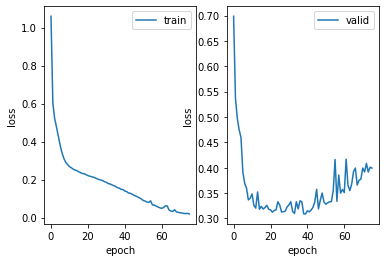

In [7]:
from matplotlib import pyplot as plt
from tqdm import tqdm

train_loss = []
valid_loss = []
epoch_num = 76

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net2 = Net2()
net2 = net2.to(device)
for epoch in tqdm(range(epoch_num)):
    train_loss.append(run_train(train_DataLoader, net2, device))
    valid_loss.append(run_valid(valid_DataLoader, net2, device))

# プロット領域の定義
fig = plt.figure()

# 描画領域を追加
train_g = fig.add_subplot(1, 2, 1)
valid_g = fig.add_subplot(1, 2, 2)

x = [i for i in range(epoch_num)]

# プロット
train_g.plot(x, train_loss, label='train')
train_g.set_xlabel('epoch')
train_g.set_ylabel('loss')
train_g.legend()

valid_g.plot(x, valid_loss, label='valid')
valid_g.set_xlabel('epoch')
valid_g.set_ylabel('loss')
valid_g.legend()

plt.show()

In [72]:
test_acc = 0.0
for x, y in test_DataLoader:
    x = x.to(device)
    y = y.to(device)
    y_pred = net2(x)
    test_acc += 1 if torch.argmax(y_pred).item()==y.item() else 0
test_acc = test_acc / float(len(test_DataLoader))
print(f'test accuracy:{test_acc}')

test accuracy:0.9115442278860569
